# Recognize if the image contains a Pizza or Donuts 

- Binary classification method using Transfer Learning                                                                                     

In [115]:
# Init
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import pathlib


In [116]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

## Data preprocessing

We cannot use tfds.load as shown in the tutorial it only loads prebuilt datasets in TFRecords format

Here we will use the custom dataset for Face Anti Spoofing

In [117]:
# Set the data dirs 

train_data_dir = './food_images/train'  
validate_data_dir = './food_images/validate' 
test_data_dir = './food_images/test'

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [118]:
# Data Pre Processing as shown in tensorflow load Images examples

IMG_HEIGHT = 160
IMG_WIDTH = 160

train_data_dir = pathlib.Path(train_data_dir)
validate_data_dir = pathlib.Path(validate_data_dir)
test_data_dir = pathlib.Path(test_data_dir)

train_image_count = len(list(train_data_dir.glob('*/*.*')))
validate_image_count = len(list(validate_data_dir.glob('*/*.*')))
test_image_count = len(list(test_data_dir.glob('*/*.*')))


CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES
 

train_list_ds = tf.data.Dataset.list_files(str(train_data_dir/'*/*'))
validate_list_ds = tf.data.Dataset.list_files(str(validate_data_dir/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))

for f in train_list_ds.take(5):
  print(f.numpy())


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


# prepare the dataset with the labels and image as features
#Apply this function to each item in the dataset using the map method:
train = train_list_ds.map(process_path)
validation = validate_list_ds.map(process_path)
test = test_list_ds.map(process_path)
 

b'food_images\\train\\pizza\\pizza (106).jpg'
b'food_images\\train\\pizza\\pizza (295).jpg'
b'food_images\\train\\donuts\\donuts (433).jpg'
b'food_images\\train\\pizza\\pizza (335).jpg'
b'food_images\\train\\donuts\\donuts (96).jpg'


The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

In [119]:
IMG_SIZE = 160 
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [120]:
#Shuffle and batch the data
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [121]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [122]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [123]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [124]:
base_model.trainable = False

In [125]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [126]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [127]:
prediction_layer = keras.layers.Dense(2 , activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [128]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [129]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [131]:
len(model.trainable_variables)

2

### Train the model

In [132]:
initial_epochs = 10
validation_steps=5

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

5/5 [==============================] - 2s 446ms/step - loss: 0.8902 - accuracy: 0.5312


In [133]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.89
initial accuracy: 0.53


In [134]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Train for 23 steps, validate for 6 steps
Epoch 1/10
23/23 [==============================] - 38s 2s/step - loss: 0.7143 - accuracy: 0.6079 - val_loss: 0.6370 - val_accuracy: 0.6448
Epoch 2/10
23/23 [==============================] - 40s 2s/step - loss: 0.6214 - accuracy: 0.6667 - val_loss: 0.5608 - val_accuracy: 0.7268
Epoch 3/10
23/23 [==============================] - 39s 2s/step - loss: 0.5385 - accuracy: 0.7186 - val_loss: 0.4991 - val_accuracy: 0.7486
Epoch 4/10
23/23 [==============================] - 39s 2s/step - loss: 0.4745 - accuracy: 0.7760 - val_loss: 0.4503 - val_accuracy: 0.7978
Epoch 5/10
23/23 [==============================] - 40s 2s/step - loss: 0.4266 - accuracy: 0.7923 - val_loss: 0.4099 - val_accuracy: 0.8142
Epoch 6/10
23/23 [==============================] - 40s 2s/step - loss: 0.3801 - accuracy: 0.8306 - val_loss: 0.3944 - val_accuracy: 0.8415
Epoch 7/10
23/23 [==============================] - 41s 2s/step - loss: 0.3505 - accuracy: 0.8511 - val_loss: 0.3759 - 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

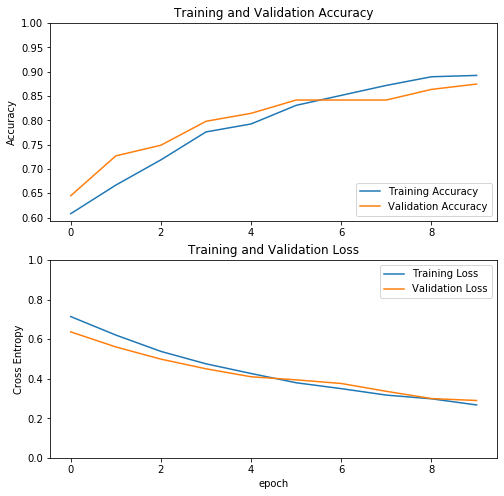

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [136]:
base_model.trainable = True

In [137]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower learning rate.

In [138]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [139]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [140]:
len(model.trainable_variables)

58

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [141]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Train for 23 steps, validate for 6 steps
Epoch 10/20
23/23 [==============================] - 50s 2s/step - loss: 0.2219 - accuracy: 0.9249 - val_loss: 0.2693 - val_accuracy: 0.8798
Epoch 11/20
23/23 [==============================] - 44s 2s/step - loss: 0.1624 - accuracy: 0.9467 - val_loss: 0.2641 - val_accuracy: 0.8798
Epoch 12/20
23/23 [==============================] - 46s 2s/step - loss: 0.1211 - accuracy: 0.9686 - val_loss: 0.2560 - val_accuracy: 0.8907
Epoch 13/20
23/23 [==============================] - 46s 2s/step - loss: 0.0914 - accuracy: 0.9822 - val_loss: 0.2605 - val_accuracy: 0.8907
Epoch 14/20
23/23 [==============================] - 43s 2s/step - loss: 0.0760 - accuracy: 0.9836 - val_loss: 0.2685 - val_accuracy: 0.8743
Epoch 15/20
23/23 [==============================] - 47s 2s/step - loss: 0.0497 - accuracy: 0.9959 - val_loss: 0.2968 - val_accuracy: 0.8689
Epoch 16/20
23/23 [==============================] - 47s 2s/step - loss: 0.0392 - accuracy: 0.9945 - val_loss: 0.

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model accuracy increases.

In [142]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

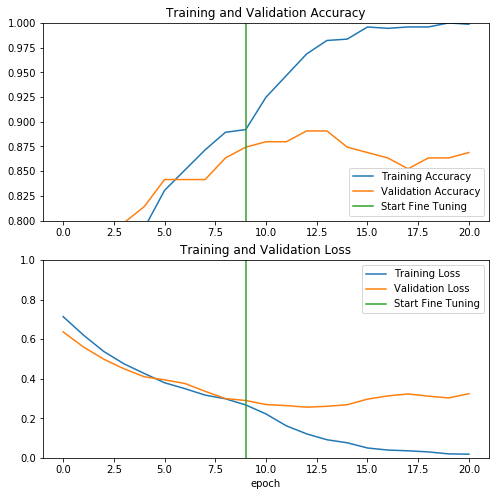

In [143]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [144]:
#Save Model
model.save('./FoodClassifierModel.h5')

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.


In [146]:
loss1,accuracy1 = model.evaluate(test_batches, steps = validation_steps)
print("test loss: {:.2f}".format(loss1))
print("test accuracy: {:.2f}".format(accuracy1))

5/5 [==============================] - 2s 413ms/step - loss: 0.8041 - accuracy: 0.7188
test loss: 0.80
test accuracy: 0.72
